<a href="https://colab.research.google.com/github/ahmedmusawir/modern-agents-youtube-series/blob/main/AGENTS_Reflexion_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### INSTALLATIONS

In [28]:
!pip install -q langchain
!pip install -q langchain_openai
!pip install -q langchain_community
!pip install -q langgraph
!pip install -q tavily-python
!pip show langchain
!pip show langgraph


Name: langchain
Version: 0.3.9
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community
Name: langgraph
Version: 0.2.53
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 


### LOADING API KEY

In [29]:
import os
os.environ["OPENAI_API_KEY"] ="sk-proj-ulX3***************8CUAYWg7y8Ge8pROt"
os.environ["TAVILY_API_KEY"] ="tvly-YhkXkYI********************bAHuL5RCyaFG"

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"REFLEXION AGENT ORCHESTRATION"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "lsv2_pt_4ce9**********8bcd65c_37d096d1b5"


### TESTING LANGSMITH & THE MODEL RESPONSE

In [30]:
from langsmith import Client

client = Client()

url = next(client.list_runs(project_name="default")).url
print(url)

https://smith.langchain.com/o/78d862d3-7879-55b5-b000-52859f3a32c5/projects/p/4c0f688e-4788-4ef1-bace-18d9411516d5/r/3d1ac675-7e16-49dc-8698-d945eacc8d66?trace_id=3d1ac675-7e16-49dc-8698-d945eacc8d66&start_time=2024-09-24T01:31:58.815054


In [31]:
from langchain_openai import ChatOpenAI
import pprint

# Create an instance of the OpenAI class
llm = ChatOpenAI(model="gpt-4o")
# llm = ChatOpenAI(model="o1-mini")

# Generate text
prompt = "Who is Sam Harris (in one sentence)"
response = llm.invoke(prompt)
# print(response)
pprint.pprint(response.content)

('Sam Harris is an American author, neuroscientist, philosopher, and podcast '
 'host known for his writings and discussions on topics such as religion, '
 'morality, neuroscience, and free will.')


# REFLEXION AGENT ORCHESTRATION

## STEP 1: THE PREP

### LOADING THE LIBRARIES & MAKING THE MODEL

In [32]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

### DEFINING THE AGENT STATE

In [12]:
from typing import TypedDict, List, Annotated

# Creating a class for the agent state
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

### SETTING THE QUERY DATA TYPE & TOOLING

In [13]:
from pydantic import BaseModel
# Importing and instantiating a tavily client
from tavily import TavilyClient

class Queries(BaseModel):
    queries: List[str]

tavily = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])


## STEP 2: IMPLEMENTING THE NODES/AGENTS

### THE PLANNING NODE/AGENT

In [14]:
# Defining the planning prompt
PLAN_PROMPT = '''You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.'''

# Creating the planning node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}


### THE RESEARCH PLANNER NODE/AGENT

In [15]:
# Defining the prompt that will be used by the agent that's doing research after the planning step
# Given a plan, it will generate some queries and pass them to Tavily Tool
RESEARCH_PLAN_PROMPT = '''You are a researcher charged with providing information that can be used when writing the following essay.
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

# Creating the reseach_plan_node
# It generates research queries based on a given task and retrieves relevant content using those queries
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])

    content = state.get('content', [])

    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}


### THE WRITER (GENERATE) NODE/AGENT

In [16]:
# Defining the writer prompt
WRITER_PROMPT = '''You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed:

------

{content}'''

# Creating the generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])

    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")

    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]

    response = model.invoke(messages)

    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


### THE CRITIQUE (REFLECTION) NODE/AGENT

In [17]:
# Defining the reflection prompt
REFLECTION_PROMPT = '''You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc.'''

# Creating the reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}


### THE CRITIQUE RESEARCHER NODE/AGENT

In [18]:
# Defining the research critique prompt
RESEARCH_CRITIQUE_PROMPT = '''You are a researcher charged with providing information that can
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

# Creating the research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {'content': content}


## STEP 3: THE GRAPH

### DEFINING THE CONDITIONAL EDGE

In [19]:
# Defining the conditional edge
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'


### DEFINING THE GRAPH

In [33]:
builder = StateGraph(AgentState)

# Adding nodes to the graph
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

# Setting the entry point of the state graph
builder.set_entry_point('planner')

# Adding the conditional edge
builder.add_conditional_edges(
    'generate',
    should_continue,
    {END: END, 'reflect': 'reflect'}
)

# Adding regular edges
builder.add_edge('planner', 'research_plan')
builder.add_edge('research_plan', 'generate')

builder.add_edge('reflect', 'research_critique')
builder.add_edge('research_critique', 'generate')


## STEP 4: ADDING MEMORY

In [34]:
!pip install -q langgraph-checkpoint-sqlite

In [35]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

graph = builder.compile(checkpointer=MemorySaver())

## STEP 5: THE GRAPH IN ACTION

### VIEWING THE GRAPH

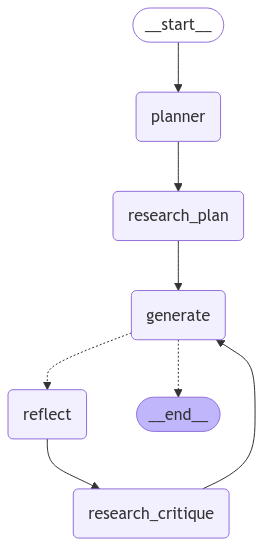

In [36]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


### RUNNING THE GRAPH

In [37]:
thread = {'configurable': {'thread_id': '1'}}
task = 'Reflection vs Refelxion Agents'

prompt = {
    'task': task,
    'max_revisions': 2,
    'revision_number': 1,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': "**Outline for Essay: Reflection vs. Reflexion Agents**\n\n**I. Introduction**\n   A. Definition of Reflection and Reflexion\n      1. Explanation of the terms in a general context\n      2. Importance of understanding the distinction between the two\n   B. Purpose of the Essay\n      1. To explore the differences and applications of reflection and reflexion agents\n      2. To highlight the significance of each in various fields (e.g., psychology, artificial intelligence, philosophy)\n\n**II. Understanding Reflection Agents**\n   A. Definition and Characteristics\n      1. Explanation of what reflection agents are\n      2. Key features: self-awareness, adaptability, and learning capabilities\n   B. Applications of Reflection Agents\n      1. In artificial intelligence: self-improving algorithms\n      2. In psychology: self-reflective practices and personal growth\n   C. Examples of Reflection Agents\n      1. Case studies or real-world applications (e.g., AI sys

### THE FINAL PRODUCT

In [38]:
# print(e['generate']['draft'])
pprint.pprint(e['generate']['draft'])

('**Reflection vs. Reflexion Agents**\n'
 '\n'
 '**I. Introduction**\n'
 '\n'
 'In the realm of cognitive science and artificial intelligence, the terms '
 '"reflection" and "reflexion" represent two distinct concepts that play '
 'crucial roles in understanding human behavior and machine learning. '
 "Reflection refers to the conscious and deliberate process of examining one's "
 'thoughts, feelings, and behaviors, while reflexion pertains to automatic '
 'responses that occur without self-awareness. Understanding the distinction '
 'between these two terms is essential, as it influences various fields, '
 'including psychology, artificial intelligence, and philosophy. This essay '
 'aims to explore the differences and applications of reflection and reflexion '
 'agents, highlighting their significance in enhancing personal growth and '
 'technological advancement.\n'
 '\n'
 '**II. Understanding Reflection Agents**\n'
 '\n'
 'Reflection agents are systems or entities that possess self